![OpenSARlab notebook banner](https://asfopensarlab.github.io/opensarlab-notebook-assets/notebook_images/blackboard-banner.png)

# Explore an Example NISAR GCOV Backscatter Time Series

### Franz J Meyer; University of Alaska Fairbanks & Josef Kellndorfer, [Earth Big Data, LLC](http://earthbigdata.com/)

Updated to support NISAR GCOV data by Alex Lewandowski, 2025-09-12

<img src="https://asfopensarlab.github.io/opensarlab-notebook-assets/notebook_images/UAFLogo_A_647.png" width="170" align="right" /></font>

This notebook introduces the analysis of multi-temporal SAR backscatter image data stacks using the NISAR L2 GCOV data product. GCOV data are a radiometrically terrain corrected and geocoded product that provides backscatter in $\gamma^{0}$ at linear (power) scale.

**This notebook covers the following data analysis concepts:**

- Search and download a stack of NISAR GCOV data
- Load GCOV data into an `xarray.Dataset`
- Subset: 
    - Spatially, in UTM or Lat/Lon coords
    - Temporally
    - By frequency
    - By polarization
- Convert between Power and dB scales
- Compute time series means
- Plot Backscatter
    - Image data
    - Histograms
    - Means
    - Animations

## 0. Search and Access Data Stack

<img src="https://asfopensarlab.github.io/opensarlab-notebook-assets/notebook_images/Nepalclimate.jpeg" width="400" align="right" /> 

This notebook will be access an x-image deep SAR data stack over blank for a first experience with time series processing. The data were acquired by NISAR's L-band sensor and are available from the [Alaska Satellite Facility](https://www.asf.alaska.edu/). 

**TODO: Update description below and plot at right when a real dataset is available**

~~Nepal is an interesting site for this analysis due to the significant seasonality of precipitation that is characteristic for this region. Nepal is said to have five seasons: spring, summer, monsoon, autumn and winter. Precipitation is low in the winter (November - March) and peaks dramatically in the summer, with top rain rates in July, August, and September (see figure to the right). As SAR is sensitive to changes in soil moisture, these weather patterns have a noticeable impact on the Radar Cross Section ($\sigma$) time series information.~~ 

We will analyze the variation of $\gamma^{0}$ values over time and will interpret them in the context of rainfall rates in the imaged area. 

---

**Create directories to hold the time series data and output plots**

In [1]:
from pathlib import Path

time_series_example_dir = Path.cwd() / "time_series_example"

data_dir = time_series_example_dir / "data"
data_dir.mkdir(parents=True, exist_ok=True)

plot_dir = time_series_example_dir / "plots"
plot_dir.mkdir(exist_ok=True)

**Use `asf_search` to search and download GCOV data**

In [2]:
import os
import asf_search as asf
# from getpass import getpass


wkt = "POLYGON((-57.759 -3.5099,-56.459 -3.5099,-56.459 -2.6352,-57.759 -2.6352,-57.759 -3.5099))"

opts=asf.ASFSearchOptions(**{
    "maxResults": 250,
    "intersectsWith": wkt,
    "processingLevel": [
        "GCOV"
    ],
    "dataset": [
        "NISAR"
    ],
    "productionConfiguration": [
        "PR"
    ],
    "host": "cmr.uat.earthdata.nasa.gov"
})

session = asf.ASFSession(cmr_host='cmr.uat.earthdata.nasa.gov')
# session.auth_with_token(getpass('UAT EDL token'))
session.auth_with_token(os.environ["UAT_TOKEN"])

response = asf.search(opts=opts)

hdf5_files = response.find_urls(extension='.h5', pattern=r'^(?!.*STATS).*DHDH.*', directAccess=False)
asf.download_urls(hdf5_files, data_dir, session=session, processes=4)

**Sample data workaround**

*TODO: Remove when there is real NISAR data*

We only have one GCOV sample product, so duplicate the file to fake a time series

In [3]:
# TODO: Delete when we have real NISAR data
# Duplicates the one sample GCOV file we have
import shutil

f = list(data_dir.glob('*.h5'))[0]
for i in range(7): 
    shutil.copy(f, f.parent / f"{f.stem}_{i}.h5")

**Collect the paths to the downloaded data**

In [4]:
gcov_files = sorted(list(data_dir.glob("*.h5")))
gcov_files

[PosixPath('/home/jovyan/uwg_demo_2025/time_series_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001.h5'),
 PosixPath('/home/jovyan/uwg_demo_2025/time_series_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001_0.h5'),
 PosixPath('/home/jovyan/uwg_demo_2025/time_series_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001_1.h5'),
 PosixPath('/home/jovyan/uwg_demo_2025/time_series_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001_2.h5'),
 PosixPath('/home/jovyan/uwg_demo_2025/time_series_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001_3.h5'),
 PosixPath('/home/jovyan/uwg_demo_2025/time_series_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001_4.h5'),
 PosixPath('/home/

**Explore the available `groups`, `datasets`, and `attributes` in one of the GCOV HDF5 files**

In [5]:
import nexusformat.nexus as nx

f = nx.nxload(gcov_files[0])
print(f.tree)

root:NXroot
  @Conventions = 'CF-1.7'
  @contact = 'nisar-sds-ops@jpl.nasa.gov'
  @institution = 'NASA JPL'
  @mission_name = 'NISAR'
  @reference_document = 'D-102274 NISAR NASA SDS Product Specification ...'
  @title = 'NISAR L2 GCOV Product'
  science:NXgroup
    LSAR:NXgroup
      GCOV:NXgroup
        grids:NXgroup
          frequencyA:NXgroup
            HHHH = float32(15984x16668)
              @DIMENSION_LIST = ['<HDF5 object reference>', '<HDF5 object refe...
              @_FillValue = nan
              @description = 'Covariance between HH and HH'
              @grid_mapping = 'projection'
              @long_name = 'Geocoded polarimetric covariance term HHHH'
              @max_value = 0.0008374068420380354
              @mean_value = 7.527565344389586e-07
              @min_value = 2.0735042643386242e-13
              @sample_stddev = 2.4732728434173623e-06
              @units = '1'
              @valid_min = 0.0
            HVHV = float32(15984x16668)
              @DIMEN

## 1. Load the Data with `xarray`

**Lazy load the data stack into an `xarray.Dataset`**

NISAR data is distributed in HDF5, not NetCDF. The NISAR `HDF5` data does not define `time`, `x`, and `y` coordinates or map them to variables. Therefor, we cannot simply use `xarray.open_mfdataset` to load the data-cube. Instead, we must define the coordinates and variables, and build the dataset ourselves.

**Use the `open_gcov` helper function below to load the data into an `xarray.Dataset`**

In [6]:
import re
import h5py
import numpy as np
import xarray as xr
import dask.array as da
from dask import delayed

_date_regex = re.compile(r"_(\d{8}T\d{6})_")
def _get_ts(filename):
    match = _date_regex.search(filename)
    if match:
        ts_str = match.group(1)
        return np.datetime64(f"{ts_str[:4]}-{ts_str[4:6]}-{ts_str[6:8]}T{ts_str[9:11]}:{ts_str[11:13]}:{ts_str[13:15]}") 
    return np.datetime64("NaT")

def open_gcov(gcov_paths, vars_to_load=("HHHH", "HVHV", "mask", "numberOfLooks", "rtcGammaToSigmaFactor"), freqs=("A","B"), max_xy_chunk=2048):
    gcov_paths = sorted(gcov_paths)
    group = {f: f"/science/LSAR/GCOV/grids/frequency{f}" for f in freqs}
    with h5py.File(gcov_paths[0], "r") as f0:
        g = f0[group[freqs[0]]]
        x, y = g["xCoordinates"][...], g["yCoordinates"][...]
        proj = g["projection"][()]
    ny, nx = len(y), len(x)
    time = np.array([_get_ts(p.name) for p in gcov_paths])
    chunks = (1, 1, min(ny, max_xy_chunk), min(nx, max_xy_chunk))  # (time, frequency, y, x)

    data_vars = {}
    for v in vars_to_load:
        per_freq = []
        for freq in freqs:
            with h5py.File(gcov_paths[0], "r") as f0:
                dt = f0[f"{group[freq]}/{v}"].dtype
            planes = [da.from_delayed(delayed(lambda p, d: h5py.File(p,"r")[d][...])(p, f"{group[freq]}/{v}"),
                                      shape=(ny, nx), dtype=dt)[None, None, ...]
                      for p in gcov_paths]
            per_freq.append(da.concatenate(planes, axis=0))
        stacked = da.concatenate(per_freq, axis=1).rechunk(chunks)
        data_vars[v] = (("time","frequency","y","x"), stacked)

    return xr.Dataset(
        data_vars=data_vars,
        coords={"time": time, "frequency": np.array(list(freqs)), "y": y, "x": x},
        attrs={"source": "NISAR L2 GCOV", "projection": proj},
    )

**Use the `open_gcov` function to load the data from HDF5**

Note that `open_gcov` defaults to loading all rasters into the Dataset, and in all dimensions (time, frequency, y, x)

In [7]:
ds = open_gcov(gcov_files)
ds

<xarray.Dataset> Size: 72GB
Dimensions:                (time: 8, frequency: 2, y: 15984, x: 16668)
Coordinates:
  * time                   (time) datetime64[s] 64B 2025-11-02T22:06:39 ... 2...
  * frequency              (frequency) <U1 8B 'A' 'B'
  * y                      (y) float64 128kB 9.819e+06 9.819e+06 ... 9.499e+06
  * x                      (x) float64 133kB 3.312e+05 3.312e+05 ... 6.646e+05
Data variables:
    HHHH                   (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    HVHV                   (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    mask                   (time, frequency, y, x) uint8 4GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    numberOfLooks          (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    rtcGammaToSigmaFactor  (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

---

We loaded some data variables that won't be used in this notebook. 

**Now load only the `HHHH` and `HVHV` backscatter rasters**

In [8]:
ds = open_gcov(gcov_files, vars_to_load=("HHHH", "HVHV"))
ds

<xarray.Dataset> Size: 34GB
Dimensions:    (time: 8, frequency: 2, y: 15984, x: 16668)
Coordinates:
  * time       (time) datetime64[s] 64B 2025-11-02T22:06:39 ... 2025-11-02T22...
  * frequency  (frequency) <U1 8B 'A' 'B'
  * y          (y) float64 128kB 9.819e+06 9.819e+06 ... 9.499e+06 9.499e+06
  * x          (x) float64 133kB 3.312e+05 3.312e+05 ... 6.645e+05 6.646e+05
Data variables:
    HHHH       (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    HVHV       (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

---

**Sample data workaround**

*TODO: Remove when there is real NISAR data*

To fake a time series with our duplicated sample data:
- Update the time dimension with fake dates
- Adjust the backscatter for each date to make our plots more interesting

In [9]:
# TODO: remove this when there is real NISAR data
# Fakes a time series by updating dates and backscatter

import pandas as pd

fake_times = pd.date_range(
    start="2025-11-02T22:06:39",
    periods=ds.sizes["time"],
    freq="D"
)

ds = ds.assign_coords(time=fake_times)

# adjust each duplicated time step's backscatter values for better test visualization
factors = 1 + 0.3 * np.sin(np.linspace(0, 2*np.pi, ds.sizes["time"]))
scaled = ds * xr.DataArray(factors, dims=["time"])
scaled = scaled.assign_attrs(ds.attrs)
ds = scaled
ds

<xarray.Dataset> Size: 68GB
Dimensions:    (frequency: 2, y: 15984, x: 16668, time: 8)
Coordinates:
  * frequency  (frequency) <U1 8B 'A' 'B'
  * y          (y) float64 128kB 9.819e+06 9.819e+06 ... 9.499e+06 9.499e+06
  * x          (x) float64 133kB 3.312e+05 3.312e+05 ... 6.645e+05 6.646e+05
  * time       (time) datetime64[ns] 64B 2025-11-02T22:06:39 ... 2025-11-09T2...
Data variables:
    HHHH       (time, frequency, y, x) float64 34GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    HVHV       (time, frequency, y, x) float64 34GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

## 2. General Examples

Before we work with the time series, here are a couple of examples related to subsetting and plotting.

### 2.1. How to Subset the Data

Time series can contain a large amount of data, so it is helpful to subset the data to the smallest appropriate area of interest.

So far, we have only lazy-loaded the data. Since we have not computed any values, we have not stored much in memory. However when we convert from Power to dB or perform statistics, we will need to load data into memory, so we should define a subset of the data first, and only load what we need. 

We can subset by spatial coordinates, temporal bounds, and/or frequency.

**Subset to a spatial extent by supplying coordinates in the dataset's native UTM**

In [10]:
# Note that you do not have to supply exact existing coords from your dataset for your slice bounds. 
# If your x coords are [0,3,6,9,12,15,18,21], using a slice(2, 14) will give you [3,6,9,12]

subset_utm = ds.sel(
    x=slice(400000.0, 500000.0),
    y=slice(9700000.0, 9600000.0),
    time=slice("2025-11-02", "2025-11-11"),
    frequency=["A", "B"]
)
subset_utm

<xarray.Dataset> Size: 6GB
Dimensions:    (frequency: 2, y: 5000, x: 5000, time: 8)
Coordinates:
  * frequency  (frequency) <U1 8B 'A' 'B'
  * y          (y) float64 40kB 9.7e+06 9.7e+06 9.7e+06 ... 9.6e+06 9.6e+06
  * x          (x) float64 40kB 4e+05 4e+05 4e+05 ... 5e+05 5e+05 5e+05
  * time       (time) datetime64[ns] 64B 2025-11-02T22:06:39 ... 2025-11-09T2...
Data variables:
    HHHH       (time, frequency, y, x) float64 3GB dask.array<chunksize=(1, 1, 212, 656), meta=np.ndarray>
    HVHV       (time, frequency, y, x) float64 3GB dask.array<chunksize=(1, 1, 212, 656), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

**Now subset to a spatial extent by supplying coordinates in WGS84 (Lat/Lon)**

`rioxarray` allows us to subset from coordinates in a different CRS while leaving the subset in its original UTM.

Subsetting in WGS84 is useful if you are grabbing some coordinates from Google Maps or Vertex.

In [11]:
# Provide your subset coords in 4326 (lat/lon), but keep the dataset in UTM.
import rioxarray

ds = ds.rio.write_crs(f"EPSG:{ds.projection}")
subset_with_lat_lon_coords = ds.rio.clip_box(
    minx=-57.5, miny=-3.6,
    maxx=-56.5, maxy=-2.6, 
    crs="EPSG:4326"
).sel(
    time=slice("2025-11-02", "2025-11-07"),
    frequency=["A", "B"]
)
subset_with_lat_lon_coords

<xarray.Dataset> Size: 6GB
Dimensions:      (frequency: 2, y: 5528, x: 5560, time: 6)
Coordinates:
  * frequency    (frequency) <U1 8B 'A' 'B'
  * y            (y) float64 44kB 9.713e+06 9.713e+06 ... 9.602e+06 9.602e+06
  * x            (x) float64 44kB 4.444e+05 4.444e+05 ... 5.556e+05 5.556e+05
  * time         (time) datetime64[ns] 48B 2025-11-02T22:06:39 ... 2025-11-07...
    spatial_ref  int64 8B 0
Data variables:
    HHHH         (time, frequency, y, x) float64 3GB dask.array<chunksize=(1, 1, 843, 484), meta=np.ndarray>
    HVHV         (time, frequency, y, x) float64 3GB dask.array<chunksize=(1, 1, 843, 484), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

### 2.2. Write an Example Plotting Function

`Matplotlib` allows a great deal of flexibility in displaying imagery and generating plots. 

Here is an example function that displays a single raster alongside its associated histogram.

*We won't use this function in the notebook but it demonstrates how you can wrap your plotting code in functions to make them easily reusable.*

In [12]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def show_image_histogram_da(
    da: xr.DataArray,
    vmin: float | None = None,
    vmax: float | None = None,
    image_downsample: int = 1,
    bins: int = 200,
    output_path: str | None = None,
):
    """
    Displays a raster image alongside a histogram showing its distribution. The image raster may
    be downsampled for efficient visualizing, however the histogram is generated using the original
    data, in the range defined by vmin and vmax.

    If vmin and vmax are not provided, the 0.05 and 0.95 quantiles will be used to remove outliers.
    
    da: DataArray containing raster data
    vmin: Minimum image value mapped to matplotlib colormap and included in histogram
    vmax: Maximum image value mapped to matplotlib colormap and included in histogram
    image_downsample: Allows downsampling of image for faster visualization (does not downsample histogram) 
    bins: Histogram bin size
    output_path: An output path for optionally saving the plot
    """

    da = da.squeeze()

    downsampled_da = da.isel(y=slice(None, None, image_downsample), 
                     x=slice(None, None, image_downsample)) if image_downsample > 1 else da

    if vmin is None or vmax is None:
        q = da.quantile([0.05, 0.95], skipna=True)
        if vmin is None:
            vmin = float(q.sel(quantile=0.05).values)
        if vmax is None:
            vmax = float(q.sel(quantile=0.95).values)

    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)   
    
    polarization = f"Polarization: {da.name}"
    date = da.time.values.astype(str).split("T")[0]
    frequency = f"Frequency: {da.frequency.values.item()}"
    title_parts = [da.source] if "source" in da.attrs else []
    title_parts.extend([polarization, frequency, date])
    title = " | ".join(title_parts)

    downsampled_da.plot.imshow(ax=ax1, cmap="gray", add_colorbar=False, vmin=vmin, vmax=vmax)
    ax1.set_title(title)

    if "projection" in raster.attrs:
        xlabel = "Longitude" if da.projection == 4326 else "Easting"
        ylabel = "Latitude" if da.projection == 4326 else "Northing"
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)

    da.plot.hist(ax=ax2, bins=bins, range=(vmin, vmax))
    ax2.set_xlabel("Backscatter")
    ax2.set_title(f"Histogram ({bins} bins)")

    fig.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, transparent=True)

    return fig, (ax1, ax2)

**We won't be calling our new function elsewhere in this notebook, so test it now:**

Note:
- We are passing an `output_path` to save a copy of the plot
- The highly skewed distribution indicates that the data are in Power scale, which is expected for NISAR GCOV products

CPU times: user 5.35 s, sys: 808 ms, total: 6.16 s
Wall time: 5.49 s


(<Figure size 1600x800 with 2 Axes>,
 (<Axes: title={'center': 'NISAR L2 GCOV | Polarization: HHHH | Frequency: A | 2025-11-02'}, xlabel='Easting', ylabel='Northing'>,
  <Axes: title={'center': 'Histogram (200 bins)'}, xlabel='Backscatter'>))

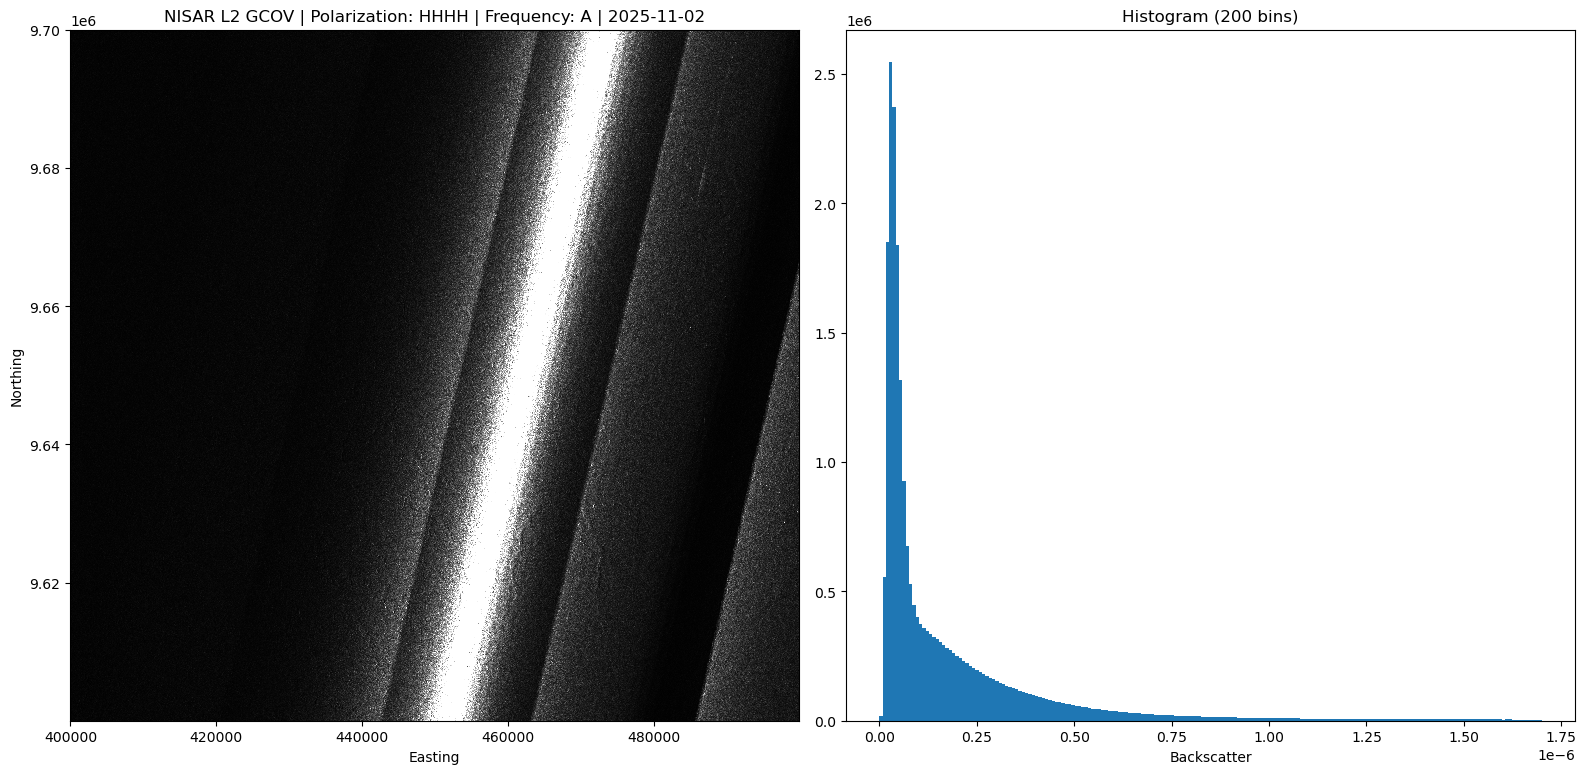

In [13]:
%%time
subset = subset_utm
date = "2025-11-02"
freq = "A"
polarization = "HHHH"

raster = subset.sel(time=date, frequency=freq)[polarization]
raster = raster.assign_attrs({**subset.attrs, **raster.attrs}) # attach global Dataset attributes to DataArray

show_image_histogram_da(raster,
                        vmin=0.0,
                        vmax=1.7e-6,
                        image_downsample=4,
                        output_path=plot_dir/f'image_and_hist_{date}_{polarization}_{freq}.png')

---
## 3. SAR Time Series Visualization, Animation, and Analysis

This section introduces you to the handling and analysis of SAR time series stacks. A focus will be put on time series visualizations, which allow us to inspect time series in more depth. 

Animations will display interactively, and be saved as gifs.

### 3.1. Subset the Data

**Create a new subset AOI**

In [14]:
subset = ds.sel(
    x=slice(450000.0, 460000.0),
    y=slice(9630000.0, 9620000.0),
    time=slice("2025-11-02", "2025-11-08"),
    frequency=["A", "B"]
)
subset

<xarray.Dataset> Size: 56MB
Dimensions:      (frequency: 2, y: 500, x: 500, time: 7)
Coordinates:
  * frequency    (frequency) <U1 8B 'A' 'B'
  * y            (y) float64 4kB 9.63e+06 9.63e+06 ... 9.62e+06 9.62e+06
  * x            (x) float64 4kB 4.5e+05 4.5e+05 4.5e+05 ... 4.6e+05 4.6e+05
  * time         (time) datetime64[ns] 56B 2025-11-02T22:06:39 ... 2025-11-08...
    spatial_ref  int64 8B 0
Data variables:
    HHHH         (time, frequency, y, x) float64 28MB dask.array<chunksize=(1, 1, 500, 204), meta=np.ndarray>
    HVHV         (time, frequency, y, x) float64 28MB dask.array<chunksize=(1, 1, 500, 204), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

### 3.2. Visually confirm the subset AOI's location

**Plot the subset bounds on a basemap to verify the correct location**

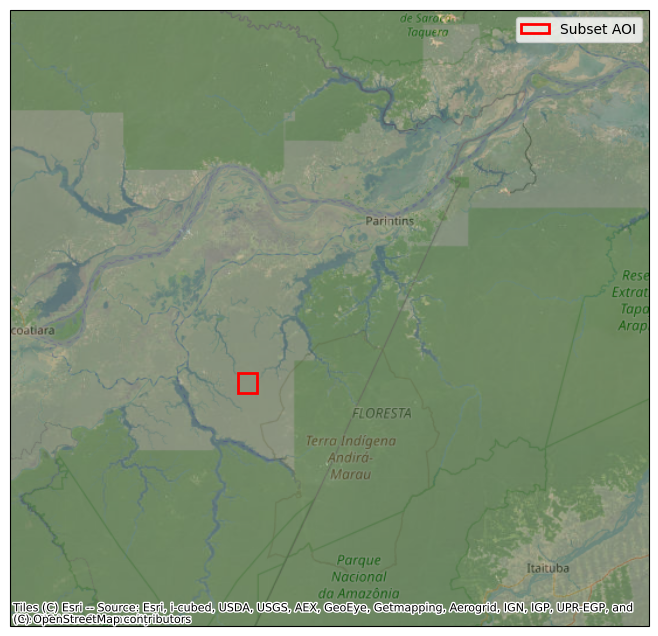

In [15]:
import cartopy.crs as ccrs
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure(figsize=(10,8))     

ax = fig.add_subplot(1, 1, 1, projection=ccrs.epsg(3857))

minx, miny, maxx, maxy = ds.rio.transform_bounds("EPSG:3857", densify_pts=21)
ax.set_extent(
    [minx, maxx, miny, maxy],
    crs=ccrs.epsg(3857))


ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.Esri.WorldImagery)
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

sub_minx, sub_miny, sub_maxx, sub_maxy = subset.rio.transform_bounds("EPSG:3857", densify_pts=21)
rect = patches.Rectangle(
    (sub_minx, sub_miny),
    sub_maxx - sub_minx,
    sub_maxy - sub_miny, 
    linewidth=2, 
    edgecolor="red", 
    facecolor="none",
    label="Subset AOI",
    transform=ccrs.epsg(3857)
)
ax.add_patch(rect)

ax.legend(handles=[rect])
plt.show()

### 3.3 Data Conversion between dB and Power Scales

Focused SAR image data may come in uncalibrated digital numbers (DN) and need to be calibrated to correspond to proper radar cross section information. However, NISAR data is already radiometrically calibrated and has a scaling factor of 1.0, so we do not need to worry about this. 

The data at hand are radiometrically terrain corrected images, which are often expressed as terrain flattened $\gamma^0$ backscattering coefficients. For forest and land cover monitoring applications $\gamma^o$ is the preferred metric.

We often visualize backscatter in log scale (dB), as plotting in a linear (Power) scale may obscure subtleties. However, we must compute statistics in linear scale, so there you may have need to convert back and forth between Power and dB.

NISAR GCOV data are provided in Power scale.

**Convert the `HHHH`, frequency A subset data from power to dB**

To convert from power to dB, apply: $\gamma^o_{dB} = 10 {\log_{10}(\gamma^o_{power})}$

Note that this is the first time we load this subset into memory, which is why the code cell takes a little time to run (~15 seconds)

In [16]:
%%time
# load subset_stack into memory once now to avoid multiple loads in subsequent code cells
subset_db = 10*np.log10(subset.sel(frequency="A").HHHH)
subset_db.load()
subset_db

CPU times: user 12.6 s, sys: 806 ms, total: 13.4 s
Wall time: 13.3 s


<xarray.DataArray 'HHHH' (time: 7, y: 500, x: 500)> Size: 14MB
array([[[-66.850248, -69.259189, -70.722828, ..., -56.532465,
         -55.138814, -55.775146],
        [-67.741596, -70.265575, -69.582494, ..., -56.354151,
         -54.031949, -53.99583 ],
        [-68.385481, -65.135493, -65.15264 , ..., -52.325989,
         -51.662813, -55.179071],
        ...,
        [-67.222354, -65.177603, -63.355756, ..., -60.422364,
         -64.754323, -60.019031],
        [-65.788857, -68.010751, -65.428672, ..., -64.230094,
         -60.17457 , -58.93254 ],
        [-62.513034, -63.087803, -64.747293, ..., -60.632788,
         -61.499568, -60.74435 ]],

       [[-65.935163, -68.344104, -69.807743, ..., -55.61738 ,
         -54.223729, -54.860061],
        [-66.826511, -69.35049 , -68.667409, ..., -55.439066,
         -53.116864, -53.080745],
        [-67.470396, -64.220408, -64.237555, ..., -51.410904,
         -50.747728, -54.263986],
...
        [-68.724957, -66.680206, -64.858358, ..., -61.924967,
         -66.256925, -61.521634],
        [-67.29146 , -69.513354, -66.931275, ..., -65.732697,
         -61.677172, -60.435143],
        [-64.015637, -64.590406, -66.249896, ..., -62.135391,
         -63.002171, -62.246953]],

       [[-68.011076, -70.420018, -71.883657, ..., -57.693294,
         -56.299642, -56.935975],
        [-68.902424, -71.426404, -70.743322, ..., -57.51498 ,
         -55.192777, -55.156658],
        [-69.546309, -66.296322, -66.313469, ..., -53.486818,
         -52.823641, -56.3399  ],
        ...,
        [-68.383183, -66.338432, -64.516584, ..., -61.583193,
         -65.915151, -61.17986 ],
        [-66.949686, -69.17158 , -66.589501, ..., -65.390923,
         -61.335398, -60.093369],
        [-63.673862, -64.248632, -65.908122, ..., -61.793616,
         -62.660397, -61.905179]]], shape=(7, 500, 500))
Coordinates:
    frequency    <U1 4B 'A'
  * y            (y) float64 4kB 9.63e+06 9.63e+06 ... 9.62e+06 9.62e+06
  * x            (x) float64 4kB 4.5e+05 4.5e+05 4.5e+05 ... 4.6e+05 4.6e+05
  * time         (time) datetime64[ns] 56B 2025-11-02T22:06:39 ... 2025-11-08...
    spatial_ref  int64 8B 0

**Plot the histogram of the dB data and confirm a normal distribution**

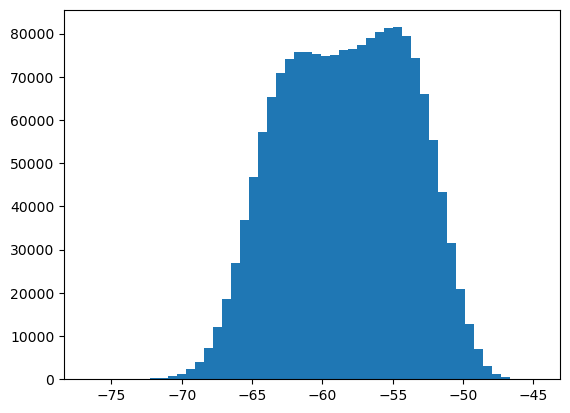

In [17]:
ax = subset_db.values.ravel()
plt.hist(ax, bins=50)
plt.show()

**Convert from dB back to power**

While dB-scaled images are often "visually pleasing", they are often not a good basis for mathematical operations on data. For instance, when we compute the mean of observations, it makes a difference whether we do that in power or dB scale. Since dB scale is a logarithmic scale, we cannot simply average data in that scale. 
    
Please note that the correct scale in which operations need to be performed is the power scale. This is critical, e.g. when speckle filters are applied, spatial operations like block averaging are performed, or time series are analyzed.

To convert from dB to power, apply: $\gamma^o_{pwr} = 10^{\frac{\gamma^o_{dB}}{10}}$

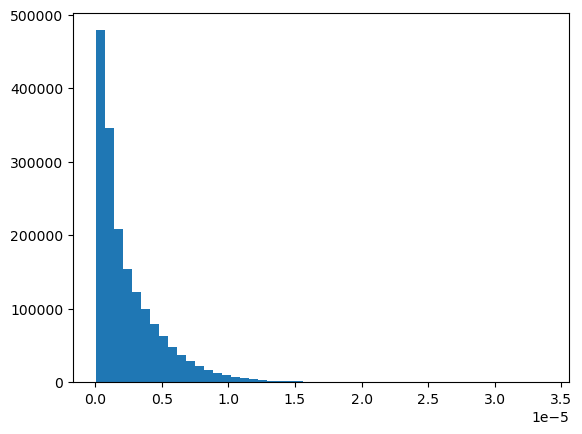

In [18]:
subset_pwr = np.power(10.0, subset_db/10.0)
ax = subset_pwr.values.ravel()
plt.hist(ax, bins=50)
plt.show()

### 3.4 Create a Time Series Animation from the dB Subset

In [19]:
%%capture
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter, PillowWriter

vmin = subset_db.quantile(0.05, skipna=True).values.item()
vmax = subset_db.quantile(0.95, skipna=True).values.item()

fig, ax = plt.subplots(figsize=(6, 6), )
frame_0 = subset_db.isel(time=0).values
im = ax.imshow(frame_0, vmin=vmin, vmax=vmax, origin="upper", cmap="grey")
cb = fig.colorbar(im, ax=ax, label="γ⁰ (dB)")
ax.set_title(np.datetime_as_string(subset_db.time.values[0], unit='s'))
ax.set_axis_off()

def animate(i):
    frame = subset_db.isel(time=i).values
    im.set_data(frame)
    ax.set_title(np.datetime_as_string(subset_db.time.values[i], unit='s'))
    return (im,)

ani = FuncAnimation(fig, animate, frames=subset_db.sizes["time"], interval=300, blit=False)

plt.show()

**Create a javascript animation of the time-series running inline in the notebook:**

In [20]:
from IPython.display import HTML

HTML(ani.to_jshtml())

**Save the animation (animation.gif):**

In [21]:
ani.save(plot_dir / "timeseries_animation.gif", writer=PillowWriter(fps=3))

### 3.5. Calculate the Time Series of Means Across the `HHHH`, frequency A Subset

To create the time series of means:
1. Compute subset means for each time-step using data in power scale ($\gamma^o_{pwr}$) .
1. Convert the resulting mean values into dB scale for visualization.

**Identify the axis on which to take the means**

Note that the Dataset dimensions are ('time', 'y', 'x')

In [22]:
subset_pwr.dims

('time', 'y', 'x')

**Compute the means in power scale:**

Since we want to take the means across the spatial dimensions (dims 1 and 2) on each day, we should pass `axis=(1, 2)` to `np.mean`.

This will compute the backscatter means spatially, while leaving the time dimension in place.

In [23]:
means_pwr = np.mean(subset_pwr, axis=(1, 2))
means_pwr

<xarray.DataArray 'HHHH' (time: 7)> Size: 56B
array([2.424814e-06, 2.993552e-06, 3.134019e-06, ..., 2.109187e-06,
       1.715608e-06, 1.856075e-06], shape=(7,))
Coordinates:
    frequency    <U1 4B 'A'
  * time         (time) datetime64[ns] 56B 2025-11-02T22:06:39 ... 2025-11-08...
    spatial_ref  int64 8B 0

**Convert the resulting mean value time-series to dB scale for visualization**

In [24]:
means_db = 10.*np.log10(means_pwr)
means_db

<xarray.DataArray 'HHHH' (time: 7)> Size: 56B
array([-56.153216, -55.238132, -55.038984, ..., -56.758848, -57.655819,
       -57.314045], shape=(7,))
Coordinates:
    frequency    <U1 4B 'A'
  * time         (time) datetime64[ns] 56B 2025-11-02T22:06:39 ... 2025-11-08...
    spatial_ref  int64 8B 0

### 3.6. Plot the time series of means

Plot both the Power and dB time series of means

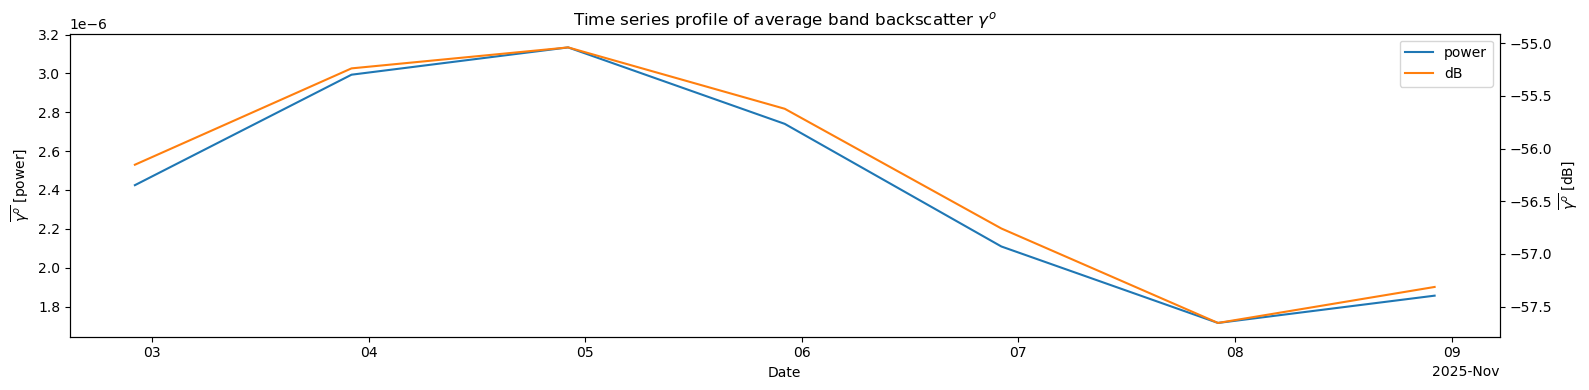

In [25]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(16, 4))

# left y-axis: power
means_pwr.plot.line(ax=ax1, x="time", label="power")
ax1.set_xlabel("Date")
ax1.set_ylabel(r"$\overline{\gamma^o}$ [power]")

# right y-axis: dB
ax2 = ax1.twinx()
means_db.plot.line(ax=ax2, x='time', color='tab:orange', label='dB')
ax2.set_ylabel(r'$\overline{\gamma^o}$ [dB]')

ax2.set_xlim(ax1.get_xlim())
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

ax1.set_title(r'Time series profile of average band backscatter $\gamma^o$')
ax2.set_title("")
plt.tight_layout()
plt.show()


### 5.7. Create Two-Panel Figure, Animating Both the Imagery and the Daily Global Means $\mu_{\gamma^0_{dB}}$

In [26]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as an
import matplotlib.dates as mdates

t_num = mdates.date2num(subset_db.time.values)                    
means = np.asarray(means_db.compute().values).reshape(-1)

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Image axis
frame_0 = subset_db.isel(time=0).values
im = ax1.imshow(frame_0, cmap="gray")
ax1.set_title(np.datetime_as_string(subset_db.time.values[0], unit='D'))
ax1.set_axis_off()

# Line axis
(l,) = ax2.plot([], [], lw=3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.set_xlim(t_num.min(), t_num.max())

ax2.set_ylim(np.nanmin(means)-0.5, np.nanmax(means)+0.5)
ax2.set_ylabel(r"Backscatter Means $\mu_{\gamma^0_{dB}}$")
ax2.set_title(str(subset_db.time.values[0].astype("datetime64[D]")))

def init():
    l.set_data([], [])
    return im, l

def animate(i):
    ts = str(subset_db.time.values[i].astype("datetime64[D]"))
    ax1.set_title(ts)
    ax2.set_title(ts)

    im.set_data(subset_db.isel(time=i).values)
    l.set_data(t_num[:i+1], means[:i+1])

    return im, l

ani = an.FuncAnimation(fig, animate, frames=len(subset_db.time), init_func=init, interval=400, blit=False)
plt.tight_layout()
plt.show()

**Create a javascript animation of the time-series running inline in the notebook:**

In [27]:
HTML(ani.to_jshtml())

**Save the animated time-series and histogram (animation_histogram.gif):**

In [28]:
ani.save(plot_dir / 'animation_histogram.gif', writer='pillow', fps=2)

*NISAR_GCOV_Time_Series_Example.ipynb - Version 1.0.0 - September 2025*

*Version Changes*

- *Created from [ALOS PALSAR example notebook](https://github.com/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/Time_Series_Example.ipynb)*